In [1]:
import torch
# import tenseal as ts
import pandas as pd
import time

from sklearn.metrics import r2_score, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import pickle
import seaborn as sns
from openfhe import *
from tqdm import tqdm
import openfhe
from openfhe import PKESchemeFeature
from sklearn.metrics import confusion_matrix

In [2]:
def load_data(path):
    saved_data = torch.load(path,weights_only=True)
    x_train = saved_data['train_data']
    x_test = saved_data['test_data']
    y_train = saved_data['train_labels']
    y_test = saved_data['test_labels']
    print("############# Data summary #############")
    print(f"x_train has shape: {x_train.shape}")
    print(f"y_train has shape: {y_train.shape}")
    print(f"x_test has shape: {x_test.shape}")
    print(f"y_test has shape: {y_test.shape}")
    print("#######################################")
    return x_train,x_test,y_train,y_test

In [3]:
def normalizare_date(x_train,x_test):
    scaler = StandardScaler()
    x_train = torch.tensor(scaler.fit_transform(x_train), dtype=torch.float32)
    x_test= torch.tensor(scaler.transform(x_test), dtype=torch.float32)
    print(x_train.shape)
    print(x_test.shape)
    return x_train,x_test


In [4]:
x_train,x_test,y_train,y_test = load_data('../../data/date_logistic_regression.pth')
x_train,x_test= normalizare_date(x_train,x_test)
x_train,x_test,y_train,y_test= x_train[:1000],x_test[:700],y_train[:1000],y_test[:700]
#vom lucra doar cu o parte din setul de date pentru a antrena mai repede modelul,
#  deoarce nu ne intereseaza acuratetea modelului 

############# Data summary #############
x_train has shape: torch.Size([24500, 16])
y_train has shape: torch.Size([24500, 1])
x_test has shape: torch.Size([10500, 16])
y_test has shape: torch.Size([10500, 1])
#######################################
torch.Size([24500, 16])
torch.Size([10500, 16])


In [5]:
class LogisticRegressionEncrypted:
    def __init__(self, n_features, learning_rate=0.1, weight_decay=0.1):
        self.bound = np.sqrt(3/n_features)
        self.weight = [0.01] * n_features
        # self.weight = np.random.uniform(-self.bound, self.bound, size=n_features).tolist()
        self.bias = np.zeros(n_features).tolist()
        self.learning_rate = learning_rate
        self.weight_decay = weight_decay
        self._delta_w = 0
        self._delta_b = 0


    def forward_on_encrypted_data(self, enc_x):
        output = []
        for x in enc_x:
            enc_sum = cc.EvalInnerProduct(x, self.weight,16)
            enc_pred = cc.EvalAdd(enc_sum, self.bias)
            enc_log = cc.EvalLogistic(enc_pred,-5,5,16)
            output.append(enc_log)
        return output

   
    def backward(self, enc_x, enc_out, enc_y):
        batch_size = len(enc_x)
        half = 2/batch_size
        delta_y = [cc.EvalSub(out , y) for out, y in zip(enc_out, enc_y)]
        delta_w = [cc.EvalMultAndRelinearize(x , dy) for dy, x in zip(delta_y, enc_x)]
        self._delta_w = cc.EvalAddManyInPlace(delta_w)
        self._delta_w = cc.EvalMult(self._delta_w, half)
        self._delta_b = cc.EvalAddManyInPlace(delta_y)
        self._delta_b = cc.EvalMult(self._delta_b, half)
       

    def update_parameters(self):
        if self._delta_w == 0:
            raise RuntimeError("Trebuie sa treci prin functia forword macar o data")
        self._delta_w = cc.EvalMult(self._delta_w, self.learning_rate)
        prod = cc.EvalMult(self.weight_decay,  self.weight)
        self._delta_w = cc.EvalAdd(self._delta_w, prod) 
        self.weight = cc.EvalSub(self.weight, self._delta_w)
        prod = cc.EvalMult(self._delta_b, self.learning_rate)
        self.bias = cc.EvalSub(self.bias,prod) 

        decr_w= cc.Decrypt(self.weight, keys.secretKey)
        decr_w = decr_w.GetRealPackedValue()
        decr_b = cc.Decrypt(self.bias, keys.secretKey)
        decr_b = decr_b.GetRealPackedValue()
    
        self._delta_w = 0
        self._delta_b = 0
    
#functii care intr-un scenariu normal ar sta la client
    def encrypt(self):
        self.weight = cc.MakeCKKSPackedPlaintext(self.weight)
        self.weight = cc.Encrypt(keys.publicKey, self.weight )
        self.bias = cc.MakeCKKSPackedPlaintext(self.bias)
        self.bias= cc.Encrypt(keys.publicKey, self.bias)
       
    def decrypt(self):
        self.weight = cc.Decrypt(self.weight, keys.secretKey)
        self.weight = self.weight.GetRealPackedValue()
        self.bias = cc.Decrypt(self.bias, keys.secretKey)
        self.bias = self.bias.GetRealPackedValue()
      
       

In [6]:
multDepth = 10
scaleModSize = 50
batchSize = len(x_test[1]) #16
parameters = openfhe.CCParamsCKKSRNS()
parameters.SetMultiplicativeDepth(multDepth)
parameters.SetScalingModSize(scaleModSize)
parameters.SetBatchSize(batchSize)
# parameters.SetScalingTechnique(openfhe.ScalingTechnique.FLEXIBLEAUTO)
parameters.SetFirstModSize(60)

parameters.SetRingDim(4096)
parameters.SetSecurityLevel(openfhe.HEStd_NotSet)

cc = openfhe.GenCryptoContext(parameters)

cc.Enable(PKESchemeFeature.PKE)
cc.Enable(PKESchemeFeature.KEYSWITCH)
cc.Enable(PKESchemeFeature.LEVELEDSHE)
cc.Enable(PKESchemeFeature.ADVANCEDSHE)
cc.Enable(PKESchemeFeature.FHE)
ring_dim = cc.GetRingDimension()
security_param= parameters.GetSecurityLevel()
keys = cc.KeyGen()

cc.EvalMultKeyGen(keys.secretKey)
cc.EvalSumKeyGen(keys.secretKey)

print(f"ring dim: {parameters.GetRingDim()}")


ring dim: 4096


In [7]:
print(x_train.shape)
x_train_list = x_train[:1000].tolist() 
print(x_train_list[:2])
print(type(x_train_list[0]))

print(y_train.shape)
y_train_list = y_train[:1000].tolist() 
print(y_train_list[:2])
print(type(y_train_list[0]))


print(x_test.shape)
x_test_list = x_test[:700].tolist() 
print(x_test_list[:2])
print(type(x_test_list[0]))


torch.Size([1000, 16])
[[0.38178399205207825, 0.9948703050613403, -0.4117799401283264, -0.5782929062843323, -0.3283218741416931, -0.48778727650642395, -0.5707517862319946, -0.4851568639278412, -0.41272860765457153, -0.3342396318912506, -0.3290841579437256, -0.343669593334198, -0.4097440242767334, 2.0449681282043457, -0.4168514609336853, -0.33037757873535156], [0.38178399205207825, 0.9948703050613403, -0.4117799401283264, -0.5782929062843323, 3.0457913875579834, -0.48778727650642395, 1.7520751953125, 2.0611891746520996, -0.41272860765457153, -0.3342396318912506, -0.3290841579437256, -0.343669593334198, 2.4405479431152344, -0.4890051484107971, 2.3989360332489014, -0.33037757873535156]]
<class 'list'>
torch.Size([1000, 1])
[[0.0], [1.0]]
<class 'list'>
torch.Size([700, 16])
[[-0.4856494069099426, -1.00515615940094, -0.4117799401283264, 1.7292275428771973, -0.3283218741416931, -0.48778727650642395, -0.5707517862319946, -0.4851568639278412, -0.41272860765457153, -0.3342396318912506, 3.03873

In [8]:
def encrypt_vector(lista):
    enc_list=[]
    for x_t_l in tqdm(lista, desc="data encryption"):
        x_test_encoded = cc.MakeCKKSPackedPlaintext(x_t_l)
        enc_x_test = cc.Encrypt(keys.publicKey, x_test_encoded)
        enc_list.append(enc_x_test)
    return enc_list

In [9]:
t_start = time.perf_counter()
enc_x_train = encrypt_vector(x_train_list)
t_end = time.perf_counter()
print(f"encryption took: {t_end-t_start}")

data encryption: 100%|██████████| 1000/1000 [00:24<00:00, 40.28it/s]

encryption took: 24.843605452000702


In [10]:
t_start = time.perf_counter()
enc_x_test = encrypt_vector(x_test_list)
t_end = time.perf_counter()
print(f"encryption took: {t_end-t_start}")

data encryption: 100%|██████████| 700/700 [00:17<00:00, 40.33it/s]

encryption took: 17.37347749899891


In [11]:
def encrypt_vector_y(lista):
    enc_list=[]
    for x_t_l in tqdm(lista, desc="data encryption"):
        x_test_encoded = cc.MakeCKKSPackedPlaintext(x_t_l*16)
        enc_x_test = cc.Encrypt(keys.publicKey, x_test_encoded)
        enc_list.append(enc_x_test)
    return enc_list

In [12]:
t_start = time.perf_counter()
enc_y_train = encrypt_vector_y(y_train_list)
t_end = time.perf_counter()
print(f"encryption took: {t_end-t_start}")

data encryption: 100%|██████████| 1000/1000 [00:24<00:00, 40.57it/s]

encryption took: 24.659033650999845


In [14]:
print(cc.Decrypt(enc_y_train[1],keys.secretKey))

(1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,  ... ); Estimated precision: 44 bits



In [18]:
def save_model(model,file_path):
    pickle.dump(model, open(file_path, "wb"))


In [13]:
def forward_test(model, x_test):
    w = torch.tensor(model.weight)
    b = torch.tensor(model.bias)
    out = (x_test.matmul(w) + b[0]).reshape(-1, 1)
    sigmo = torch.sigmoid(out)
    return sigmo

In [14]:
y = y_test[:700].detach().numpy()

In [ ]:
# model = LogisticRegressionEncrypted(x_train.shape[1])

In [15]:
model = LogisticRegressionEncrypted(x_train.shape[1])
batch_size = 512
t_start = time.perf_counter()
for epoch in tqdm(range(5),desc="epoch"):
    t_start_epoch = time.perf_counter()
    indices = np.random.permutation(len(enc_x_train))
    epoch_data = [enc_x_train[idx] for idx in indices]
    epoch_targets = [enc_y_train[idx] for idx in indices]


    for batch in range(0, len(epoch_data),batch_size):
        model.encrypt()
        batch_data = epoch_data[batch: batch+batch_size]
        batch_targets = epoch_targets[batch: batch+batch_size]

        batch_out = model.forward_on_encrypted_data(batch_data)
        model.backward(batch_data, batch_out, batch_targets)
        model.update_parameters()
        model.decrypt()
    
    pred = forward_test(model,x_test[:700])
    t_end_epoch = time.perf_counter()
    print(f"Epoca: {epoch} a durat {t_end_epoch-t_start_epoch} secunde")
    correct = torch.abs(y_test - pred.reshape(-1, 1)) < 0.5
    correct= correct.float().mean()
    print(f"Epoca: {epoch}. Acuratetea pe setul de date necriptate: {correct}")
t_end = time.perf_counter()

# save_model(model,'lo_r_trained_on_encrypted_data.pkl')

print(f"Antrenarea modelului a durat: {t_end-t_start} secunde")

epoch:   0%|          | 0/5 [00:00<?, ?it/s]

epoch:  20%|██        | 1/5 [03:53<15:32, 233.07s/it]

Epoca: 0 a durat 233.06980368100085 secunde
Epoca: 0. Acuratetea pe setul de date necriptate: 0.9585714340209961


epoch:  40%|████      | 2/5 [07:39<11:27, 229.32s/it]

Epoca: 1 a durat 226.69236275700132 secunde
Epoca: 1. Acuratetea pe setul de date necriptate: 0.9585714340209961


epoch:  60%|██████    | 3/5 [11:26<07:35, 227.96s/it]

Epoca: 2 a durat 226.3276885689993 secunde
Epoca: 2. Acuratetea pe setul de date necriptate: 0.9671428799629211


epoch:  80%|████████  | 4/5 [15:13<03:47, 227.72s/it]

Epoca: 3 a durat 227.35034362400074 secunde
Epoca: 3. Acuratetea pe setul de date necriptate: 0.9700000286102295


epoch: 100%|██████████| 5/5 [19:13<00:00, 230.65s/it]

Epoca: 4 a durat 239.79715041599957 secunde
Epoca: 4. Acuratetea pe setul de date necriptate: 0.9742857217788696
Antrenarea modelului a durat: 1153.261658599 secunde


se observa ca modelul converge foarte repede in 5 epoci ajunge la o acuratete mai buna ca cea pe date clare

In [ ]:
# save_model(model,'lo_r_trained_on_encrypted_data.pkl')

In [16]:
def metrics_on_clear_data(model, x, y):
    t_start = time.perf_counter()
    pred = forward_test(model,x)
    t_end = time.perf_counter()
    print(f"predictiile pe testul de date necriptate au durat:{(t_end - t_start):.20f} secunde")

    binary_preds = (np.array(pred) > 0.5).astype(int)
    correct = torch.abs(y - pred.reshape(-1, 1)) < 0.5
    correct= correct.float().mean()

    print(f"Acuratetea pe datele criptate este: {correct}")
    cm = confusion_matrix(y, binary_preds,  labels=[0, 1])
    plt.figure(figsize=(8,6))
    sns.set_style("dark")
    sns.heatmap(cm, annot=True, fmt='d', cmap="Purples", xticklabels=['Fără risc', 'Cu risc crescut'], yticklabels=[ 'Fără risc', 'Cu risc crescut'],linewidth=.5)
    plt.xlabel('Predicții')
    plt.ylabel('Valori reale')
    plt.title('Model antrenat pe date criptate predictii pe date clare')
    plt.legend(title=f'Acuratete: {correct:.4f}', title_fontsize=12)
    plt.savefig('../../plots/logistic_regression/lo_r_trained_on_encrypted_data_confusion_matrix_on_clear_data.png')
    plt.show()

    return correct
  

predictiile pe testul de date necriptate au durat:0.00419781900018278975 secunde
Acuratetea pe datele criptate este: 0.9685714244842529


/tmp/ipykernel_85327/2055864040.py:19: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title=f'Acuratete: {correct:.4f}', title_fontsize=12)


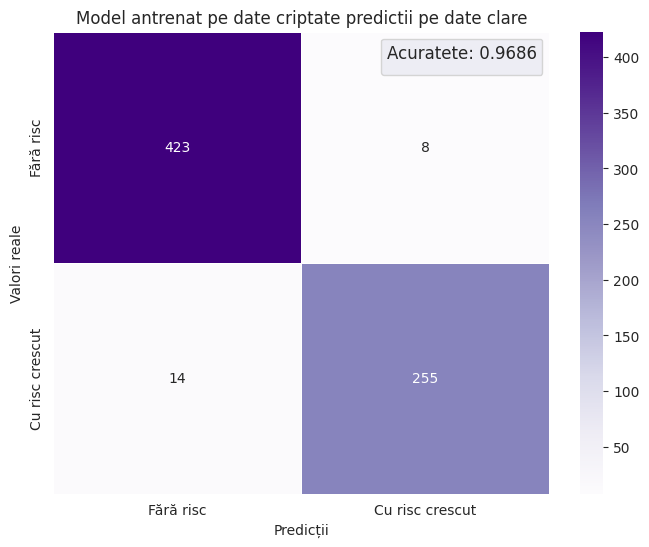

In [17]:
plain_accuracy= metrics_on_clear_data(model,x_train[:700], y_train[:700])

In [23]:
def feature_importance(model, feature_names):
    weights = model.weight
    print(weights)

    weights = np.abs(weights)
    weights = weights / np.sum(weights)

    sorted_indices = np.argsort(weights)
    feature_names_sorted = [feature_names[i] for i in sorted_indices]
    weights_sorted = weights[sorted_indices]

    plt.figure(figsize=(16, 6))
    sns.barplot(y=feature_names_sorted, x=weights_sorted, hue=feature_names_sorted, palette=sns.cubehelix_palette( n_colors=16), orient="h", legend=False)

    plt.xlabel('Importanța caracteristicilor', fontsize=12)
    plt.ylabel('Caracteristici', fontsize=12)
    plt.title('Grafic de importanța caracteristicilor model antrenat pe date criptate', fontsize=14)

    plt.grid(True, linestyle='--', alpha=0.7)
    plt.savefig("../../plots/logistic_regression/lo_r_trained_on_encrypted_data_feature_importance.png")
    plt.show()



['Age', 'Gender', 'Chest Pain', 'High Blood Pressure', 'Irregular Heartbeat', 'Shortness Of Breath', 'Fatigue Weakness', 'Dizziness', 'Swelling Edema', 'Neck Jaw Pain', 'Excessive Sweating', 'Persistent Cough', 'Chest Discomfort', 'Cold Hands Feet', 'Snoring Sleep Apnea', 'Anxiety Doom']
[0.3116792865550032, -0.06251563511117558, 0.13971541723035608, 0.19375138196311853, 0.11133035568207567, 0.11970026352050858, 0.0998813260729156, 0.10575000043845408, 0.0864777050115936, 0.09828467770652205, 0.043784174070204004, 0.07708260197029056, 0.10586453989692429, 0.07136681053978308, 0.1132424149987122, 0.047623087108349685]


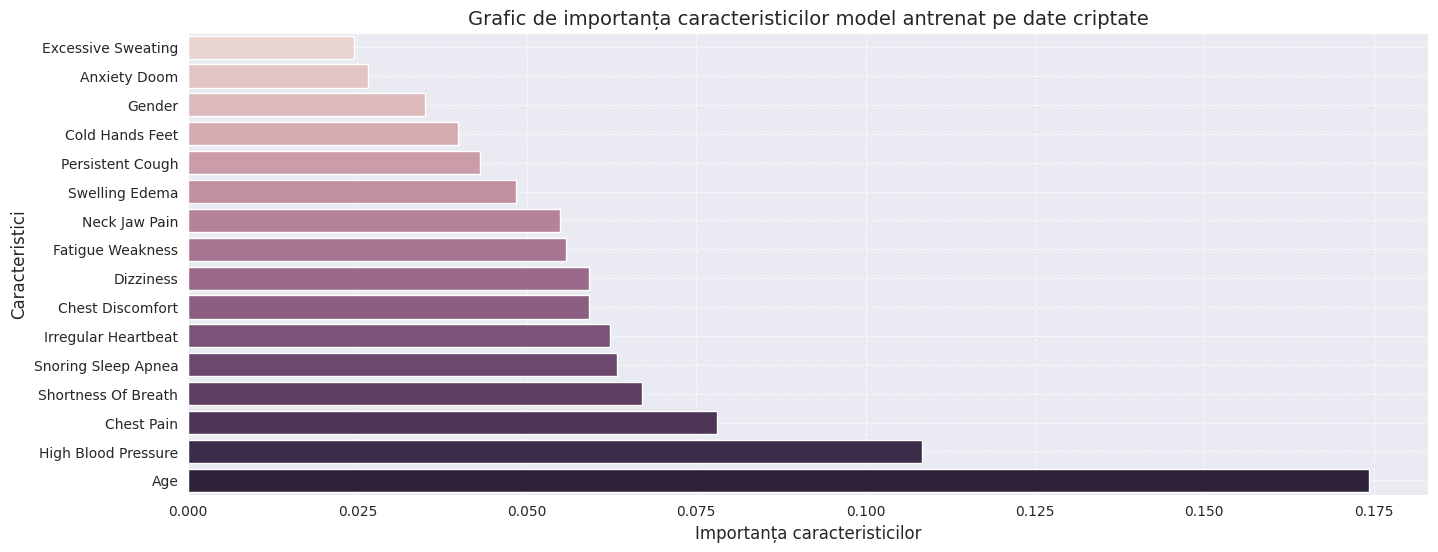

In [24]:
csv = pd.read_csv('../../data/stroke_risk_dataset.csv')
csv = csv.drop(columns=["stroke_risk_percentage", "at_risk", "nausea_vomiting"])
header = csv.columns.tolist()

formatted_features = [feat.replace('_', ' ').title() for feat in header]
print(formatted_features)
feature_importance(model,formatted_features) 

In [18]:
def metrics_on_encrypted_data(model, enc_x, y):
    #predictiile sunt se vor intoarce criptate
    t_start = time.perf_counter()
    model.encrypt()
    enc_list_pred = model.forward_on_encrypted_data(enc_x)
    model.decrypt()
    t_end = time.perf_counter()
    print(f"Predictiile pe testul de date criptat au durat:{(t_end - t_start):.20f} secunde")
    # return enc_list_pred[0]
    #trebuie decriptate pentru a calcula metricile
    list_pred = []
    t_start = time.perf_counter()
    for enc_pred in enc_list_pred:
        decript = cc.Decrypt(enc_pred, keys.secretKey)
        decript.SetLength(1)
        decoded_values = decript.GetCKKSPackedValue()
        list_pred.append(decoded_values[0].real)
    t_end = time.perf_counter()
    print(f"Decriptarea predictiilor a durat:{(t_end - t_start):.20f} secunde")
    
    list_pred = torch.tensor(list_pred)
    
    binary_preds = (np.array(list_pred) > 0.5).astype(int)
    correct = torch.abs(y - list_pred.reshape(-1, 1)) < 0.5
    correct= correct.float().mean()

    print(f"Acuratetea pe datele criptate este: {correct}")
    cm = confusion_matrix(y, binary_preds,  labels=[0, 1])
    plt.figure(figsize=(8,6))
    sns.set_style("dark")
    sns.heatmap(cm, annot=True, fmt='d', cmap="Purples", xticklabels=['Fără risc', 'Cu risc crescut'], yticklabels=[ 'Fără risc', 'Cu risc crescut'],linewidth=.5)
    plt.xlabel('Predicții')
    plt.ylabel('Valori reale')
    plt.legend(title=f'Acuratete: {correct:.4f}', title_fontsize=12)
    plt.title('Matricea de confuzie date criptate -model antrenat pe date criptate')
    plt.savefig('../../plots/logistic_regression/lo_r_trained_on_encrypted_data_confusion_matrix_on_encrypted_data.png')
    plt.show()

Predictiile pe testul de date criptat au durat:322.07056455299971275963 secunde
Decriptarea predictiilor a durat:7.81272514700140163768 secunde
Acuratetea pe datele criptate este: 0.9742857217788696


/tmp/ipykernel_85327/2282255074.py:34: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title=f'Acuratete: {correct:.4f}', title_fontsize=12)


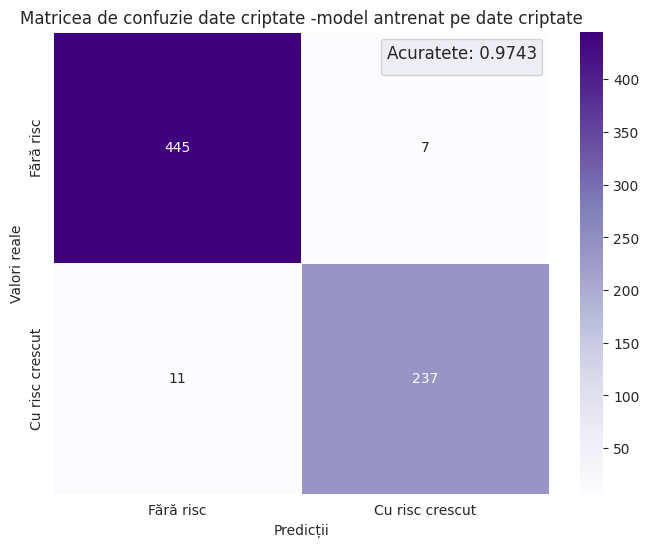

In [19]:
accuracy_enc= metrics_on_encrypted_data(model,enc_x_test,y_test[:700])